In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!git clone https://github.com/LiyuanLucasLiu/RAdam.git

Cloning into 'RAdam'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 298 (delta 9), reused 10 (delta 2), pack-reused 274
Receiving objects: 100% (298/298), 948.24 KiB | 1.33 MiB/s, done.
Resolving deltas: 100% (138/138), done.


In [3]:
!unzip ./drive/My\ Drive/cifar.zip

Archive:  ./drive/My Drive/cifar.zip
   creating: cifar/
  inflating: cifar/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/cifar/
  inflating: __MACOSX/cifar/._.DS_Store  
  inflating: cifar/labels.txt        
  inflating: __MACOSX/cifar/._labels.txt  
   creating: cifar/test/
  inflating: cifar/test/0_cat.png    
   creating: __MACOSX/cifar/test/
  inflating: __MACOSX/cifar/test/._0_cat.png  
  inflating: cifar/test/1000_dog.png  
  inflating: __MACOSX/cifar/test/._1000_dog.png  
  inflating: cifar/test/1001_airplane.png  
  inflating: __MACOSX/cifar/test/._1001_airplane.png  
  inflating: cifar/test/1002_ship.png  
  inflating: __MACOSX/cifar/test/._1002_ship.png  
  inflating: cifar/test/1003_deer.png  
  inflating: __MACOSX/cifar/test/._1003_deer.png  
  inflating: cifar/test/1004_ship.png  
  inflating: __MACOSX/cifar/test/._1004_ship.png  
  inflating: cifar/test/1005_automobile.png  
  inflating: __MACOSX/cifar/test/._1005_automobile.png  
  inflating: cifar/tes

In [0]:
import torch
import torchvision

In [0]:
import glob
import os

In [0]:
from RAdam.radam import RAdam

In [7]:
train_imgs = glob.glob('./cifar/train/*.png')
test_imgs = glob.glob('./cifar/test/*.png')
classes = []
with open('./cifar/labels.txt','r') as f:
  classes = f.readlines()
class_to_idx_dict = {class_.replace("\n",""):idx for idx, class_ in enumerate(classes)}
class_to_idx_dict

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [0]:
transform = {
    'train':torchvision.transforms.Compose([
                                            # torchvision.transforms.RandomResizedCrop(32),
                                            # torchvision.transforms.RandomHorizontalFlip(),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
}

In [0]:
from PIL import Image

In [0]:
class CIFAR10Dataset(torch.utils.data.Dataset):
  def __init__(self, img_path, transform=None, mode='train',class_to_idx_dict=class_to_idx_dict):
    super(CIFAR10Dataset, self).__init__()
    self.img_path = img_path
    self.transform = transform
    self.mode = mode
    self.class_to_idx_dict = class_to_idx_dict

  def __getitem__(self, idx):
    img_p = self.img_path[idx]
    img = Image.open(img_p)
    label = img_p.split('/')[-1].split('_')[-1].replace('.png','')
    label_idx = self.class_to_idx_dict[label]

    if self.transform:
      img = self.transform[self.mode](img)

    return img, label_idx

  def __len__(self):
    return len(self.img_path)

In [0]:
train_ds = CIFAR10Dataset(train_imgs, transform=transform,mode='train',class_to_idx_dict=class_to_idx_dict)
test_ds = CIFAR10Dataset(test_imgs, transform=transform, mode='test',class_to_idx_dict=class_to_idx_dict)

In [0]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1024, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1024, shuffle=False)
dl_dict = {'train':train_dl,'test':test_dl}

In [0]:
criterion = torch.nn.CrossEntropyLoss()

In [0]:
epoch_num=100

In [0]:
def train(train_dl, test_dl, net, criterion, hist,optimizer='adam', epoch_num=epoch_num):
  print('START {}:'.format(optimizer))
  net.to(device)
  torch.backends.cudnn.benchmark =True
  if optimizer == 'adam':
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))
  elif optimizer == 'radam':
    optimizer = RAdam(net.parameters(),lr=1e-3, betas=(0.9, 0.999))
  else:
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

  for epoch in range(epoch_num):
    net.train()
    epoch_loss = 0.
    epoch_correct = 0.
    epoch_imgs = 0
    for i,batch in enumerate(train_dl):
        #print(i+1)
        imgs,labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        epoch_imgs += len(labels)
        optimizer.zero_grad()
        output = net(imgs)
        loss = criterion(output, labels)        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss
        epoch_correct += sum(output.argmax(1)==labels)

    t_l = epoch_loss/(i+1)
    t_a = epoch_correct/epoch_imgs
    hist['train_loss'].append(t_l)
    hist['train_acc'].append(t_a)
    print("Epoch {}: Loss: {} Acc: {}".format(epoch+1,t_l,t_a)) 

    net.eval()
    val_loss = 0.
    val_correct = 0.
    val_imgs = 0
    with torch.no_grad():
      for i,batch in enumerate(test_dl):
          imgs,labels = batch
          imgs = imgs.to(device)
          labels = labels.to(device)
          val_imgs += len(labels)
          output = net(imgs)
          loss = criterion(output, labels)        
          
          val_loss += loss
          val_correct += sum(output.argmax(1)==labels) 

    l = val_loss/(i+1)
    a = val_correct/val_imgs
    hist['test_loss'].append(l)
    hist['test_acc'].append(a)
    print("Val: Loss: {} Acc: {}".format(l,a))

  return net, hist


In [0]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = torch.nn.Linear(2048, 10)

In [0]:
hist = {"train_loss":[],"train_acc":[], "test_loss":[],"test_acc":[]}

In [47]:
resnet50_adam, resnet50_adamhist = train(train_dl,test_dl,resnet50,criterion,hist,'adam')

START adam:
Epoch 1: Loss: 0.8872897624969482 Acc: 0.6959199905395508
Val: Loss: 0.631921648979187 Acc: 0.7856000065803528
Epoch 2: Loss: 0.3960806429386139 Acc: 0.8655399680137634
Val: Loss: 0.5742872357368469 Acc: 0.8093999624252319
Epoch 3: Loss: 0.2554859220981598 Acc: 0.915120005607605
Val: Loss: 0.5451623797416687 Acc: 0.8258000016212463
Epoch 4: Loss: 0.17242765426635742 Acc: 0.9419599771499634
Val: Loss: 0.6417657136917114 Acc: 0.8118999600410461
Epoch 5: Loss: 0.1326039731502533 Acc: 0.9558599591255188
Val: Loss: 0.6135292053222656 Acc: 0.8274999856948853
Epoch 6: Loss: 0.10408709943294525 Acc: 0.9645999670028687
Val: Loss: 0.6585853695869446 Acc: 0.8273999691009521
Epoch 7: Loss: 0.08719367533922195 Acc: 0.9696599841117859
Val: Loss: 0.7061968445777893 Acc: 0.8245999813079834
Epoch 8: Loss: 0.07005075365304947 Acc: 0.9766599535942078
Val: Loss: 0.7100147604942322 Acc: 0.830299973487854
Epoch 9: Loss: 0.06590723991394043 Acc: 0.9775599837303162
Val: Loss: 0.6974130868911743 Ac

In [0]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = torch.nn.Linear(2048,10)

In [49]:
resnet50_radam, resnet50_radamhist = train(train_dl,test_dl,resnet50,criterion,hist,'radam')

START radam:
Epoch 1: Loss: 1.589906096458435 Acc: 0.4411199986934662
Val: Loss: 0.8642480969429016 Acc: 0.705299973487854
Epoch 2: Loss: 0.5808088183403015 Acc: 0.801859974861145
Val: Loss: 0.6194747090339661 Acc: 0.7894999980926514
Epoch 3: Loss: 0.25501593947410583 Acc: 0.9170199632644653
Val: Loss: 0.6611301302909851 Acc: 0.7979999780654907
Epoch 4: Loss: 0.15428616106510162 Acc: 0.9479399919509888
Val: Loss: 0.7880226373672485 Acc: 0.7928000092506409
Epoch 5: Loss: 0.1528913378715515 Acc: 0.9477199912071228
Val: Loss: 0.7820644378662109 Acc: 0.8012999892234802
Epoch 6: Loss: 0.1252162903547287 Acc: 0.9569599628448486
Val: Loss: 0.7286397814750671 Acc: 0.8151999711990356
Epoch 7: Loss: 0.08780761808156967 Acc: 0.9707799553871155
Val: Loss: 0.7782555818557739 Acc: 0.8116999864578247
Epoch 8: Loss: 0.08427096158266068 Acc: 0.9723999500274658
Val: Loss: 0.7603844404220581 Acc: 0.818399965763092
Epoch 9: Loss: 0.07414804399013519 Acc: 0.9749999642372131
Val: Loss: 0.7502784132957458 Ac

NameError: ignored

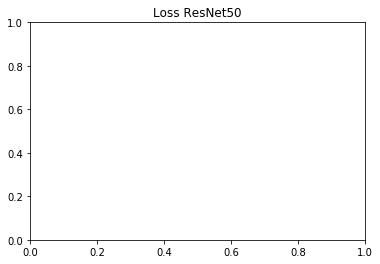

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1,epoch_num+1)

plt.title('Loss ResNet50')
plt.plot(epochs, resnet50_radamhist['train_loss'],'ro',label='radam_train')
plt.plot(epochs, resnet50_radamhist['test_loss'],'r',label='radam_test')
plt.plot(epochs, resnet50_adamhist['train_loss'],'go',label='adam_train')
plt.plot(epochs, resnet50_adamhist['test_loss'],'g',label='adam_test')
# plt.ylim((0.0,0.1))
plt.legend()

plt.figure()
plt.title('Acc ResNet50')
plt.plot(epochs, resnet50_radamhist['train_acc'],'ro',label='radam_train')
plt.plot(epochs, resnet50_radamhist['test_acc'],'r',label='radam_test')
plt.plot(epochs, resnet50_adamhist['train_acc'],'go',label='adam_train')
plt.plot(epochs, resnet50_adamhist['test_acc'],'g',label='adam_test')
# plt.ylim((0.96,1.0))
plt.legend()



In [0]:
mobilenetv2 = torchvision.models.mobilenet_v2(pretrained=True)
mobilenetv2.classifier[1]= torch.nn.Linear(1280,10)
mobilenetv2_adam, mobilenetv2_adamhist = train(train_dl,test_dl,mobilenetv2,criterion,hist,'adam')

In [0]:
mobilenetv2 = torchvision.models.mobilenet_v2(pretrained=True)
mobilenetv2.classifier[1]= torch.nn.Linear(1280,10)
mobilenetv2_radam, mobilenetv2_radamhist = train(train_dl,test_dl,mobilenetv2,criterion,hist,'radam')

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, epoch_num+1)

plt.title('Loss mobilenetv2')
plt.plot(epochs, mobilenetv2_radamhist['train_loss'],'ro',label='radam_train')
plt.plot(epochs, mobilenetv2_radamhist['test_loss'],'r',label='radam_test')
plt.plot(epochs, mobilenetv2_adamhist['train_loss'],'go',label='adam_train')
plt.plot(epochs, mobilenetv2_adamhist['test_loss'],'g',label='adam_test')
# plt.ylim((0.0,0.1))
plt.legend()

plt.figure()
plt.title('Acc mobilenetv2')
plt.plot(epochs, mobilenetv2_radamhist['train_acc'],'ro',label='radam_train')
plt.plot(epochs, mobilenetv2_radamhist['test_acc'],'r',label='radam_test')
plt.plot(epochs, mobilenetv2_adamhist['train_acc'],'go',label='adam_train')
plt.plot(epochs, mobilenetv2_adamhist['test_acc'],'g',label='adam_test')
# plt.ylim((0.96,1.0))
plt.legend()

